In [1]:
import os
from pathlib import Path
import glob
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from skimage.io import imread, imshow, imsave
from keras.preprocessing.image import load_img, array_to_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPooling2D, UpSampling2D, Flatten, Input
from keras.optimizers import Adam, Adadelta, Adagrad
from keras import backend as K
from sklearn.model_selection import train_test_split
np.random.seed(111)
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))
# Any results you write to the current directory are saved as output.

In [3]:
!pwd

/Users/nbhadra/Downloads/Computational/Phenotype_trajectory/Codes/Github_repo_Nivedita/OCR/denoising-dirty-documents


In [4]:
import glob
train_images = glob.glob('/Users/nbhadra/Downloads/Computational/Phenotype_trajectory/Codes/Github_repo_Nivedita/OCR/denoising-dirty-documents/train/*.png')
train_labels = glob.glob('/Users/nbhadra/Downloads/Computational/Phenotype_trajectory/Codes/Github_repo_Nivedita/OCR/denoising-dirty-documents/train_cleaned/*.png')
test_images = glob.glob('/Users/nbhadra/Downloads/Computational/Phenotype_trajectory/Codes/Github_repo_Nivedita/OCR/denoising-dirty-documents/test/*.png')
print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))

# Lets' plot a few samples
# First row will be raw data, second row will be the corresponding cleaned images
samples = train_images[:3] + train_labels[:3]

Total number of images in the training set:  144
Total number of cleaned images found:  144
Total number of samples in the test set:  72


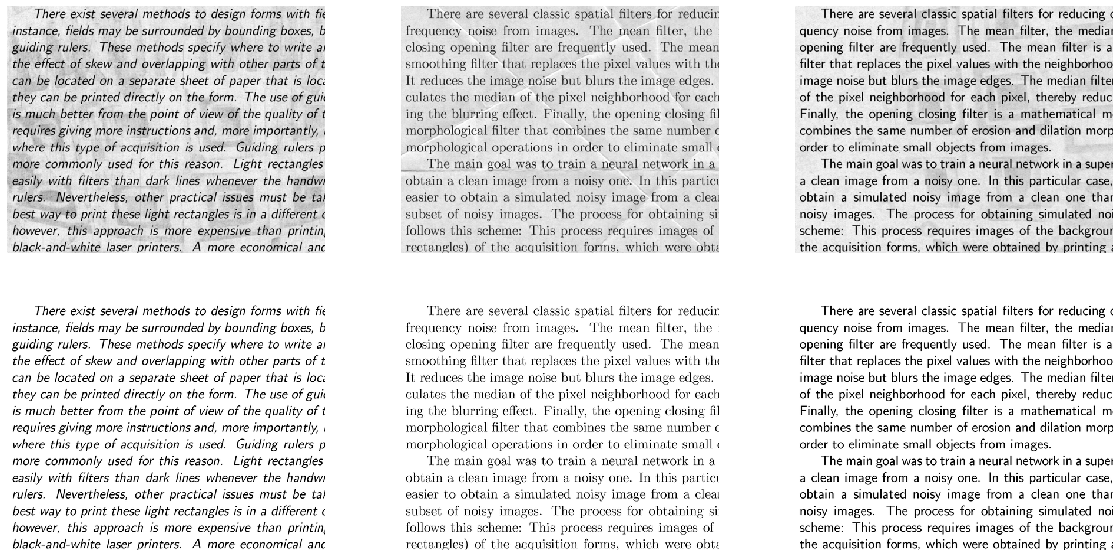

In [5]:
f, ax = plt.subplots(2, 3, figsize=(20,10))
for i, img in enumerate(samples):
    img = imread(img)
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')
plt.show()   

In [6]:
def build_autoenocder():
    input_img = Input(shape=(420,540,1), name='image_input')
    
    #enoder 
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
   
    #decoder

    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = UpSampling2D((2,2), name='upsample3')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv3')(x)
    
    #model
    autoencoder = Model(inputs=input_img, outputs=x)
    autoencoder.compile(optimizer='Adagrad', loss='binary_crossentropy')
    return autoencoder


In [7]:
autoencoder = build_autoenocder()
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 420, 540, 1)]     0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 420, 540, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 210, 270, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 210, 270, 32)      9248      
_________________________________________________________________
upsample3 (UpSampling2D)     (None, 420, 540, 32)      0         
_________________________________________________________________
Conv3 (Conv2D)               (None, 420, 540, 1)       289       
Total params: 9,857
Trainable params: 9,857
Non-trainable params: 0
___________________________________________________________

In [8]:
X = []
Y = []

for img in train_images:
    img = load_img(img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    X.append(img)

for img in train_labels:
    img = load_img(img, grayscale=True,target_size=(420,540))
    img = img_to_array(img).astype('float32')/255.
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)


/Users/nbhadra/anaconda3/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:107: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)


In [9]:
# Split the dataset into training and validation. Always set the random state!!
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.3, random_state=111)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)


Total number of training samples:  (100, 420, 540, 1)
Total number of validation samples:  (44, 420, 540, 1)


In [10]:
# Train your model
autoencoder.fit(X_train, y_train, epochs=50, batch_size=8, validation_data=(X_valid, y_valid))

Epoch 1/50
13/13 [==============================] - 30s 2s/step - loss: 0.5928 - val_loss: 0.5000
Epoch 2/50
13/13 [==============================] - 28s 2s/step - loss: 0.4474 - val_loss: 0.3971
Epoch 3/50
13/13 [==============================] - 35s 3s/step - loss: 0.3708 - val_loss: 0.3475
Epoch 4/50
13/13 [==============================] - 54s 4s/step - loss: 0.3343 - val_loss: 0.3240
Epoch 5/50
13/13 [==============================] - 38s 3s/step - loss: 0.3160 - val_loss: 0.3088
Epoch 6/50
13/13 [==============================] - 28s 2s/step - loss: 0.3016 - val_loss: 0.2961
Epoch 7/50
13/13 [==============================] - 30s 2s/step - loss: 0.2904 - val_loss: 0.2858
Epoch 8/50
13/13 [==============================] - 34s 3s/step - loss: 0.2812 - val_loss: 0.2774
Epoch 9/50
13/13 [==============================] - 48s 4s/step - loss: 0.2733 - val_loss: 0.2696
Epoch 10/50
13/13 [==============================] - 70s 5s/step - loss: 0.2663 - val_loss: 0.2629
Epoch 11/50
13/13 [

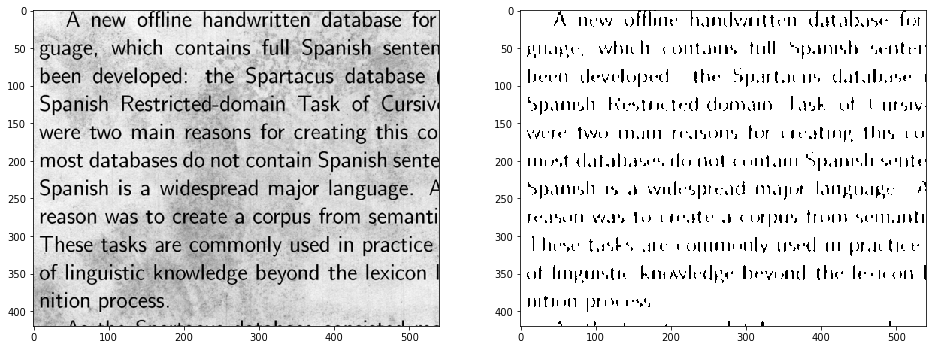

In [19]:
sample_test = load_img(test_images[20], grayscale=True, target_size=(420,540))
sample_test = img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(autoencoder.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(16,9))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()